In [28]:
from sys import path
path.append("../src") 
path.append("..")   

from train_mixed_model import MixedResNet, eval_transform, DEVICE, BEST_MODEL_PATH as BEST_MIXED_MODEL
from train_LSTM import VideoLSTM, HIDDEN_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT, DEVICE as LSTM_DEVICE

import torch
import torch.nn as nn
from torchvision import transforms
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries & paths loaded")


Libraries & paths loaded


In [25]:
# === CONFIG: BATCH LIST ===

REAL_DIR = "../inference/videos/real"
FAKE_DIR = "../inference/videos/fake"

# Make a list of tuples: (video_path, video_name)
video_list = []

for v in os.listdir(REAL_DIR):
    if v.endswith(".mp4"):
        video_list.append( (os.path.join(REAL_DIR, v), f"real_{v.split('.')[0]}") )

for v in os.listdir(FAKE_DIR):
    if v.endswith(".mp4"):
        video_list.append( (os.path.join(FAKE_DIR, v), f"fake_{v.split('.')[0]}") )

print(f"Found {len(video_list)} videos: {video_list[:2]}...")


Found 20 videos: [('../inference/videos/real/id0_0008.mp4', 'real_id0_0008'), ('../inference/videos/real/id0_0009.mp4', 'real_id0_0009')]...


In [17]:
# === CONFIG ===
VIDEO_PATH = "../inference/videos/real/id0_0000.mp4"  # <-- 👈 Replace with your test Celeb-DF video
VIDEO_NAME = "real_000"

RGB_DIR = "../dataset/inference_rgb"
FLOW_DIR = "../dataset/inference_flow"
FEAT_DIR = "../features/inference"

os.makedirs(os.path.join(RGB_DIR, VIDEO_NAME), exist_ok=True)
os.makedirs(os.path.join(FLOW_DIR, VIDEO_NAME), exist_ok=True)
os.makedirs(FEAT_DIR, exist_ok=True)

print("Folders ready")


Folders ready


In [18]:
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    out_path = os.path.join(RGB_DIR, VIDEO_NAME, f"frame_{frame_id:04d}.jpg")
    cv2.imwrite(out_path, frame)
    frame_id += 1

cap.release()
print(f"Extracted {frame_id} frames.")


Extracted 469 frames.


In [19]:
from utils.optical_flow_utils import compute_optical_flow, normalize_flow, save_flow_as_image

frames = sorted(os.listdir(os.path.join(RGB_DIR, VIDEO_NAME)))

for i in range(len(frames)-1):
    f1 = os.path.join(RGB_DIR, VIDEO_NAME, frames[i])
    f2 = os.path.join(RGB_DIR, VIDEO_NAME, frames[i+1])

    img1 = cv2.imread(f1)
    img2 = cv2.imread(f2)

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    flow = compute_optical_flow(gray1, gray2)
    norm_flow = normalize_flow(flow)

    out_path = os.path.join(FLOW_DIR, VIDEO_NAME)
    os.makedirs(out_path, exist_ok=True)
    save_flow_as_image(norm_flow, os.path.join(out_path, f"flow_{i:04d}.jpg"))

print(f"Computed optical flow: {len(frames)-1} flow images.")


Computed optical flow: 468 flow images.


In [20]:
# === Load frozen MixedResNet===
BEST_MIXED_MODEL = "../models/mixed_model/best_mixed_model.pth"

# === Load model ===
model = MixedResNet().to(DEVICE)
assert os.path.exists(BEST_MIXED_MODEL), f"Path not found: {BEST_MIXED_MODEL}"
model.load_state_dict(torch.load(BEST_MIXED_MODEL, map_location=DEVICE))
model.head = torch.nn.Identity()
model.eval()

# === Video directories ===
rgb_vid_dir = os.path.join(RGB_DIR, VIDEO_NAME)
flow_vid_dir = os.path.join(FLOW_DIR, VIDEO_NAME)

assert os.path.exists(rgb_vid_dir), f" RGB folder missing: {rgb_vid_dir}"
assert os.path.exists(flow_vid_dir), f"Flow folder missing: {flow_vid_dir}"

frames = sorted(os.listdir(rgb_vid_dir))
frames = [f for f in frames if f.endswith(".jpg")]  # only images
frames = frames[:-1]  # drop last

print(f"Found {len(frames)} RGB frames for feature extraction.")

video_feats = []

with torch.no_grad():
    for frame in tqdm(frames, desc="Extracting features"):
        rgb_path = os.path.join(rgb_vid_dir, frame)
        flow_name = frame.replace("frame_", "flow_")
        flow_path = os.path.join(flow_vid_dir, flow_name)

        if not os.path.exists(flow_path):
            print(f"[WARN] Missing flow frame: {flow_path}")
            continue

        rgb = Image.open(rgb_path).convert("RGB")
        of  = Image.open(flow_path).convert("RGB")

        rgb = eval_transform(rgb).unsqueeze(0).to(DEVICE)
        of  = eval_transform(of).unsqueeze(0).to(DEVICE)

        feat = model(rgb, of).squeeze().cpu().numpy()
        video_feats.append(feat)

# === Stack & save ===
if video_feats:
    feats_array = np.stack(video_feats)  # (T, 1024)
    feat_file = os.path.join(FEAT_DIR, f"{VIDEO_NAME}.npy")
    np.save(feat_file, feats_array)
    print(f"✅ Saved features: {feat_file} shape={feats_array.shape}")
else:
    print("No features extracted. Check your frames.")


Found 468 RGB frames for feature extraction.


Extracting features: 100%|██████████| 468/468 [00:13<00:00, 34.69it/s]

✅ Saved features: ../features/inference/real_000.npy shape=(468, 1024)


In [21]:
# === Load trained LSTM ===
lstm_path = "../models/lstm_model/best_lstm.pth"

# same settings as training
lstm_model = VideoLSTM(
    input_size=1024,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT
).to(LSTM_DEVICE)

lstm_model.load_state_dict(torch.load(lstm_path, map_location=LSTM_DEVICE))
lstm_model.eval()

features = np.load(feat_file)
features = torch.from_numpy(features).unsqueeze(0).float().to(LSTM_DEVICE)  # (1,T,1024)

with torch.no_grad():
    output = lstm_model(features)
    probs = torch.softmax(output, dim=1).cpu().numpy().squeeze()

    pred = np.argmax(probs)
    label = "REAL" if pred == 0 else "FAKE"

print(f"\n✅ Final prediction: {label}")
print(f"Confidence: Real={probs[0]:.4f}, Fake={probs[1]:.4f}")



✅ Final prediction: REAL
Confidence: Real=0.6878, Fake=0.3122


In [26]:
# === FULL BATCH INFERENCE ===

for VIDEO_PATH, VIDEO_NAME in video_list:
    print(f"\n=== Processing {VIDEO_NAME} ===")

    # 1️⃣ Create folders
    os.makedirs(os.path.join(RGB_DIR, VIDEO_NAME), exist_ok=True)
    os.makedirs(os.path.join(FLOW_DIR, VIDEO_NAME), exist_ok=True)

    # 2️⃣ Extract frames
    cap = cv2.VideoCapture(VIDEO_PATH)
    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        out_path = os.path.join(RGB_DIR, VIDEO_NAME, f"frame_{frame_id:04d}.jpg")
        cv2.imwrite(out_path, frame)
        frame_id += 1
    cap.release()
    print(f"  Frames extracted: {frame_id}")

    # 3️⃣ Compute optical flow
    from utils.optical_flow_utils import compute_optical_flow, normalize_flow, save_flow_as_image

    frames = sorted(os.listdir(os.path.join(RGB_DIR, VIDEO_NAME)))
    for i in range(len(frames) - 1):
        f1 = os.path.join(RGB_DIR, VIDEO_NAME, frames[i])
        f2 = os.path.join(RGB_DIR, VIDEO_NAME, frames[i + 1])

        img1 = cv2.imread(f1)
        img2 = cv2.imread(f2)
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        flow = compute_optical_flow(gray1, gray2)
        norm_flow = normalize_flow(flow)
        out_flow_dir = os.path.join(FLOW_DIR, VIDEO_NAME)
        os.makedirs(out_flow_dir, exist_ok=True)
        save_flow_as_image(norm_flow, os.path.join(out_flow_dir, f"flow_{i:04d}.jpg"))
    print(f"  Optical flow computed: {len(frames) - 1}")

    # 4️⃣ Extract features
    rgb_vid_dir = os.path.join(RGB_DIR, VIDEO_NAME)
    flow_vid_dir = os.path.join(FLOW_DIR, VIDEO_NAME)
    frames = sorted(os.listdir(rgb_vid_dir))
    frames = [f for f in frames if f.endswith(".jpg")][:-1]

    video_feats = []
    with torch.no_grad():
        for frame in tqdm(frames, desc="Extracting features"):
            rgb_path = os.path.join(rgb_vid_dir, frame)
            flow_name = frame.replace("frame_", "flow_")
            flow_path = os.path.join(flow_vid_dir, flow_name)
            if not os.path.exists(flow_path):
                continue
            rgb = Image.open(rgb_path).convert("RGB")
            of = Image.open(flow_path).convert("RGB")
            rgb = eval_transform(rgb).unsqueeze(0).to(DEVICE)
            of = eval_transform(of).unsqueeze(0).to(DEVICE)
            feat = model(rgb, of).squeeze().cpu().numpy()
            video_feats.append(feat)

    if not video_feats:
        print("No features extracted!")
        continue

    feats_array = np.stack(video_feats)
    feat_file = os.path.join(FEAT_DIR, f"{VIDEO_NAME}.npy")
    np.save(feat_file, feats_array)

    # 5️⃣ Predict with LSTM
    features = torch.from_numpy(feats_array).unsqueeze(0).float().to(LSTM_DEVICE)
    with torch.no_grad():
        output = lstm_model(features)
        probs = torch.softmax(output, dim=1).cpu().numpy().squeeze()
        pred = np.argmax(probs)
        label = "REAL" if pred == 0 else "FAKE"
        print(f"  ✅ Final: {VIDEO_NAME} => {label} | Real={probs[0]:.4f}, Fake={probs[1]:.4f}")



=== Processing real_id0_0008 ===
  Frames extracted: 464
  Optical flow computed: 463


Extracting features: 100%|██████████| 463/463 [00:13<00:00, 35.16it/s]


  ✅ Final: real_id0_0008 => FAKE | Real=0.0004, Fake=0.9996

=== Processing real_id0_0009 ===
  Frames extracted: 520
  Optical flow computed: 519


Extracting features: 100%|██████████| 519/519 [00:15<00:00, 34.29it/s]


  ✅ Final: real_id0_0009 => REAL | Real=0.9710, Fake=0.0290

=== Processing real_id0_0002 ===
  Frames extracted: 350
  Optical flow computed: 349


Extracting features: 100%|██████████| 349/349 [00:09<00:00, 35.91it/s]


  ✅ Final: real_id0_0002 => REAL | Real=0.9925, Fake=0.0075

=== Processing real_id0_0003 ===
  Frames extracted: 529
  Optical flow computed: 528


Extracting features: 100%|██████████| 528/528 [00:14<00:00, 37.45it/s]


  ✅ Final: real_id0_0003 => REAL | Real=0.9868, Fake=0.0132

=== Processing real_id0_0001 ===
  Frames extracted: 303
  Optical flow computed: 302


Extracting features: 100%|██████████| 302/302 [00:08<00:00, 37.62it/s]


  ✅ Final: real_id0_0001 => REAL | Real=0.9894, Fake=0.0106

=== Processing real_id0_0000 ===
  Frames extracted: 469
  Optical flow computed: 468


Extracting features: 100%|██████████| 468/468 [00:13<00:00, 35.53it/s]


  ✅ Final: real_id0_0000 => REAL | Real=0.6878, Fake=0.3122

=== Processing real_id0_0004 ===
  Frames extracted: 326
  Optical flow computed: 325


Extracting features: 100%|██████████| 325/325 [00:08<00:00, 36.98it/s]


  ✅ Final: real_id0_0004 => FAKE | Real=0.1399, Fake=0.8601

=== Processing real_id0_0005 ===
  Frames extracted: 459
  Optical flow computed: 458


Extracting features: 100%|██████████| 458/458 [00:12<00:00, 37.00it/s]


  ✅ Final: real_id0_0005 => REAL | Real=0.6772, Fake=0.3228

=== Processing real_id0_0007 ===
  Frames extracted: 479
  Optical flow computed: 478


Extracting features: 100%|██████████| 478/478 [00:13<00:00, 35.97it/s]


  ✅ Final: real_id0_0007 => REAL | Real=0.5152, Fake=0.4848

=== Processing real_id0_0006 ===
  Frames extracted: 534
  Optical flow computed: 533


Extracting features: 100%|██████████| 533/533 [00:14<00:00, 35.60it/s]


  ✅ Final: real_id0_0006 => FAKE | Real=0.0594, Fake=0.9406

=== Processing fake_id0_id16_0008 ===
  Frames extracted: 464
  Optical flow computed: 463


Extracting features: 100%|██████████| 463/463 [00:12<00:00, 35.76it/s]


  ✅ Final: fake_id0_id16_0008 => FAKE | Real=0.0005, Fake=0.9995

=== Processing fake_id0_id16_0009 ===
  Frames extracted: 520
  Optical flow computed: 519


Extracting features: 100%|██████████| 519/519 [00:14<00:00, 36.42it/s]


  ✅ Final: fake_id0_id16_0009 => REAL | Real=0.6910, Fake=0.3090

=== Processing fake_id0_id16_0001 ===
  Frames extracted: 303
  Optical flow computed: 302


Extracting features: 100%|██████████| 302/302 [00:08<00:00, 35.29it/s]


  ✅ Final: fake_id0_id16_0001 => FAKE | Real=0.1392, Fake=0.8608

=== Processing fake_id0_id16_0000 ===
  Frames extracted: 469
  Optical flow computed: 468


Extracting features: 100%|██████████| 468/468 [00:12<00:00, 37.11it/s]


  ✅ Final: fake_id0_id16_0000 => FAKE | Real=0.0448, Fake=0.9552

=== Processing fake_id0_id16_0002 ===
  Frames extracted: 350
  Optical flow computed: 349


Extracting features: 100%|██████████| 349/349 [00:09<00:00, 36.38it/s]


  ✅ Final: fake_id0_id16_0002 => FAKE | Real=0.0064, Fake=0.9936

=== Processing fake_id0_id16_0003 ===
  Frames extracted: 529
  Optical flow computed: 528


Extracting features: 100%|██████████| 528/528 [00:13<00:00, 38.67it/s]


  ✅ Final: fake_id0_id16_0003 => FAKE | Real=0.0042, Fake=0.9958

=== Processing fake_id0_id16_0007 ===
  Frames extracted: 479
  Optical flow computed: 478


Extracting features: 100%|██████████| 478/478 [00:13<00:00, 36.61it/s]


  ✅ Final: fake_id0_id16_0007 => FAKE | Real=0.0404, Fake=0.9596

=== Processing fake_id0_id16_0006 ===
  Frames extracted: 534
  Optical flow computed: 533


Extracting features: 100%|██████████| 533/533 [00:14<00:00, 35.65it/s]


  ✅ Final: fake_id0_id16_0006 => FAKE | Real=0.0007, Fake=0.9993

=== Processing fake_id0_id16_0004 ===
  Frames extracted: 326
  Optical flow computed: 325


Extracting features: 100%|██████████| 325/325 [00:09<00:00, 35.62it/s]


  ✅ Final: fake_id0_id16_0004 => FAKE | Real=0.0365, Fake=0.9635

=== Processing fake_id0_id16_0005 ===
  Frames extracted: 459
  Optical flow computed: 458


Extracting features: 100%|██████████| 458/458 [00:12<00:00, 38.09it/s]


  ✅ Final: fake_id0_id16_0005 => FAKE | Real=0.0373, Fake=0.9627



Confusion Matrix:
 [[7 3]
 [1 9]]

Classification Report:
              precision    recall  f1-score   support

        REAL       0.88      0.70      0.78        10
        FAKE       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



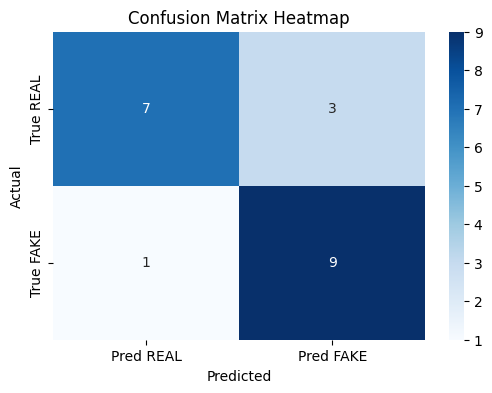

In [29]:
# === FULL BATCH INFERENCE ===
# Store true and predicted labels
true_labels = []
pred_labels = []

for VIDEO_PATH, VIDEO_NAME in video_list:
    # Ground truth from filename
    true = 0 if VIDEO_NAME.startswith("real_") else 1
    true_labels.append(true)

    # Load prediction
    feat_file = os.path.join(FEAT_DIR, f"{VIDEO_NAME}.npy")
    if not os.path.exists(feat_file):
        print(f"[WARN] Missing features for: {VIDEO_NAME}")
        pred_labels.append(-1)
        continue

    feats_array = np.load(feat_file)
    features = torch.from_numpy(feats_array).unsqueeze(0).float().to(LSTM_DEVICE)
    with torch.no_grad():
        output = lstm_model(features)
        probs = torch.softmax(output, dim=1).cpu().numpy().squeeze()
        pred = np.argmax(probs)
        pred_labels.append(pred)

# Remove any -1 predictions (missing)
pairs = [(t, p) for t, p in zip(true_labels, pred_labels) if p >= 0]
true_clean, pred_clean = zip(*pairs)

# === 1️⃣ Text confusion matrix ===
cm = confusion_matrix(true_clean, pred_clean)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(true_clean, pred_clean, target_names=["REAL", "FAKE"]))

# === 2️⃣ Plot heatmap ===
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred REAL", "Pred FAKE"],
            yticklabels=["True REAL", "True FAKE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()
